<a href="https://colab.research.google.com/github/yoonsongg/Project4/blob/main/Project_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.kaggle.com/hhalalwi/yelp-light/version/1?select=reviews_with_splits_lite.csv

In [1]:
from argparse import Namespace
from collections import Counter
import json
import os
import re
import string

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import tqdm

In [2]:
raw_data = pd.read_csv('/content/drive/MyDrive/reviews_with_splits_lite.csv')
raw_data.head()

,rating,review,split
0,negative,all i can say is that a i had no other option ...,train
1,negative,i went here once when my long time stylist mov...,train
2,negative,i don t know why i stopped here for lunch this...,train
3,negative,did i order the wrong thing ? or maybe it was ...,train
4,negative,i went here for restaurant week . the restaura...,train


In [3]:
raw_data['rating'].value_counts()

negative    28000
positive    28000
Name: rating, dtype: int64

In [4]:
raw_data['split'].value_counts()

train    39200
val       8400
test      8400
Name: split, dtype: int64

In [5]:
raw_data['review'].iloc[0]

'all i can say is that a i had no other option then to go with time warner cable for my internet service n nand b . . . . n nif you don t have a local number it will be an absolute nightmare to pay your bill ! you can go through the ring of automated messages only to get to a live person after min then be told they will charge you so you must go through the automated service . . . . repeat . i cringe when it comes time to pay my bill each month . n nif you are lucky enough to avoid using them i suggest you do so ! '

In [6]:
#간단한 전처리
import re

def preprocessing(text):
    text = text.lower()
    text = re.sub('[-=+,#/\?:^.@*\"※~ㆍ!』‘|\(\)\[\]`\'…》\”\“\’·]', '', text)
    #text = text.split(' ')
    return text

raw_data['review'] = raw_data['review'].apply(preprocessing)

In [7]:
raw_data.head()

,rating,review,split
0,negative,all i can say is that a i had no other option ...,train
1,negative,i went here once when my long time stylist mov...,train
2,negative,i don t know why i stopped here for lunch this...,train
3,negative,did i order the wrong thing or maybe it was a...,train
4,negative,i went here for restaurant week the restauran...,train


In [ ]:
#dataset 나누기

train = raw_data[raw_data['split'] == 'train']
val = raw_data[raw_data['split'] == 'val']
test = raw_data[raw_data['split'] == 'test']

In [8]:
from torch.utils.data import Dataset

class ReviewDataset(Dataset):
    def __init__(self, review_df, vectorizer):
        self.review_df = review_df
        self._vectorizer = vectorizer

        self.train_df = self.review_df[self.review_df.split=='train']
        self.train_size = len(self.train_df)

        self.val_df = self.review_df[self.review_df.split=='val']
        self.validation_size = len(self.val_df)

        self.test_df = self.review_df[self.review_df.split=='test']
        self.test_size = len(self.test_df)

        self._lookup_dict = {'train': (self.train_df, self.train_size),
                             'val': (self.val_df, self.validation_size),
                             'test': (self.test_df, self.test_size)}

        self.set_split('train')
    
    @classmethod
    def load_dataset_and_make_vectorizer(cls, review_csv):
        review_df = review_csv
        #review_df = pd.read_csv(review_csv)
        return cls(review_df, ReviewVectorizer.from_dataframe(review_df))

    def load_dataset_and_load_vectorizer(cls, review_csv, vectorizer_filepath):
        review_df = review_csv
        vectorizer = cls.load_vectorizer_only(vectorizer_filepath)
        return cls(review_df, vectorizer)

    @staticmethod
    def load_vectorizer_only(vectorizer_filepath):
        with open(vectorizer_filepath) as fp:
            return ReviewVectorizer.from_serializable(json.load(fp))
    
    def save_vectorizer(self, vectorizer_filepath):
        with open(vectorizer_filepath, "w") as fp:
            json.dump(self._vectorizer.to_serializable(), fp)
    
    def get_vectorizer(self):
        return self._vectorizer
    
    def set_split(self, split = 'train'):
        self._target_split = split
        self._target_df, self._target_size = self._lookup_dict[split]

    def __len__(self):
        return self._target_size

    def __getitem__(self, index):
        row = self._target_df.iloc[index]
        review_vector = self._vectorizer.vectorize(row.review)
        rating_index = self._vectorizer.rating_vocab.lookup_token(row.rating)

        return {'x_data' : review_vector, 'y_target' : rating_index}

    def get_num_batches(self, batch_size):
        return len(self) // batch_size



In [9]:
#리뷰 단어들 토큰으로 만들기(token_to_idx = 토큰-정수 매칭해둔 딕셔너리)

class Vocabulary:
    def __init__(self, token_to_idx = None, add_unk = True, unk_token = "<UNK>"):
        if token_to_idx is None:
            token_to_idx = {}
        self._token_to_idx = token_to_idx
        
        self._idx_to_token = {idx : token for token, idx in self._token_to_idx.items()}

        self._add_unk = add_unk
        self._unk_token = unk_token

        self.unk_index = -1
        if add_unk:
            self.unk_index = self.add_token(unk_token)


    def to_serializable(self):
        return {'token_to_idx' : self._token_to_idx,
                'add_unk' : self._add_unk,
                'unk_token' : self._unk_token}

    @classmethod
    def from_serializable(cls, contents):
        return cls(**contents)

    def add_token(self, token):
        if token in self._token_to_idx:
            index = self._token_to_idx[token]
        else:
            index = len(self._token_to_idx)
            self._token_to_idx[token] = index
            self._idx_to_token[index] = token
        
        return index
    
    def add_many(self, tokens):
        return [self.add_token(token) for token in tokens]

    def lookup_token(self, token):
        if self.unk_index >=0 :
            return self._token_to_idx.get(token, self.unk_index)
        else:
            return self._token_to_idx[token]

    def lookup_index(self, index):
        if index not in self._idx_to_token:
            raise KeyError("Vocabulary에 인덱스(%d)가 없습니다" % index)
        return self._idx_to_token[index]

    def __str__(self):
        return "<Vocabulary(size = %d)>" %len(self)

    def __len__(self):
        return len(self._token_to_idx)



In [10]:
#위의 토큰을 정수로 바꾸기(벡터화)

class ReviewVectorizer:
    def __init__(self, review_vocab, rating_vocab):
        self.review_vocab = review_vocab
        self.rating_vocab = rating_vocab

    def vectorize(self, review):
        one_hot = np.zeros(len(self.review_vocab), dtype = np.float32)

        for token in review.split(" "):
            if token not in string.punctuation:
                one_hot[self.review_vocab.lookup_token(token)] = 1
        return one_hot


    @classmethod
    def from_dataframe(cls, review_df, cutoff = 25):
        review_vocab = Vocabulary(add_unk = True)
        rating_vocab = Vocabulary(add_unk = False)

        for rating in sorted(set(review_df.rating)):
            rating_vocab.add_token(rating)

        word_counts = Counter()
        for review in review_df.review:
            for word in review.split(" "):
                if word not in string.punctuation:
                    word_counts[word] += 1

        for word, count in word_counts.items():
            if count > cutoff:
                review_vocab.add_token(word)

        return cls(review_vocab, rating_vocab)

    @classmethod
    def from_serializable(cls, contents):
        review_vocab = Vocabulary.from_serializable(contents['review_vocab'])
        rating_vocab = Vocabulary.from_serializable(contents['rating_vocab'])

        return cls(review_vocab = review_vocab, rating_vocab = rating_vocab)

    def to_serializable(self):
        return {'review_vocab': self.review_vocab.to_serializable(),
                'rating_vocab': self.rating_vocab.to_serializable()}


In [11]:
#dataLoader

from torch.utils.data import DataLoader

def generate_batches(dataset, batch_size, shuffle = True, drop_last = True, device = "cpu"):
    dataloader = DataLoader(dataset = dataset, batch_size = batch_size, shuffle = shuffle, drop_last = drop_last)

    for data_dict in dataloader:
        out_data_dict = {}
        for name, tensor in data_dict.items():
            out_data_dict[name] = data_dict[name].to(device)
        yield out_data_dict

In [ ]:
#간단한 퍼셉트론 모델

# import torch.nn as nn

# class ReviewClassifier(nn.Module):
#     def __init__(self, num_features):
#         super(ReviewClassifier, self).__init__()
#         self.fc1 = nn.Linear(in_features = num_features, out_features = 1)

#     def forward(self, x_in, apply_sigmoid = False):
#         y_out = self.fc1(x_in).squeeze()
#         if apply_sigmoid:
#             y_out = torch.sigmoid(y_out)
#         return y_out


In [13]:
#MLP 하나 더 
hidden_dim = 300
import torch.nn as nn

class ReviewClassifier(nn.Module):
    def __init__(self, num_features):
        super(ReviewClassifier, self).__init__()
        self.fc1 = nn.Linear(num_features, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, out_features = 1)


    def forward(self, x_in, apply_sigmoid = False):
        intermediate_vector = F.relu(self.fc1(x_in))
        #y_out = self.fc2(intermediate_vector)
        y_out = self.fc2(intermediate_vector).squeeze()
        if apply_sigmoid:
            y_out = torch.sigmoid(y_out)
        return y_out


In [14]:
def set_seed_everywhere(seed, cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)

def handle_dirs(dirpath):
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)

In [15]:
#train 준비

from argparse import Namespace

args = Namespace(
    frequency_cutoff = 25,
    model_state_file = 'model.pth',
    review_csv = raw_data,
    save_dir='model_storage/ch3/yelp/',
    vectorizer_file = 'vectorizer.json',

    batch_size = 128,
    early_stopping_criteria = 5,
    learning_rate = 0.001,
    num_epochs = 100,
    seed = 1337,
    catch_keyboard_interrupt=True,
    cuda=True,
    expand_filepaths_to_save_dir=True,
    reload_from_files=False,
)
if args.expand_filepaths_to_save_dir:
    args.vectorizer_file = os.path.join(args.save_dir,
                                        args.vectorizer_file)

    args.model_state_file = os.path.join(args.save_dir,
                                         args.model_state_file)
    
    print("파일 경로: ")
    print("\t{}".format(args.vectorizer_file))
    print("\t{}".format(args.model_state_file))
    
# CUDA 체크
if not torch.cuda.is_available():
    args.cuda = False

print("CUDA 사용여부: {}".format(args.cuda))

args.device = torch.device("cuda" if args.cuda else "cpu")

# 재현성을 위해 시드 설정
set_seed_everywhere(args.seed, args.cuda)

# 디렉토리 처리
handle_dirs(args.save_dir)

파일 경로: 
	model_storage/ch3/yelp/vectorizer.json
	model_storage/ch3/yelp/model.pth
CUDA 사용여부: True


In [16]:
#훈련상태 딕셔너리

def make_train_state(args):
    return {'stop_early': False,
            'early_stopping_step': 0,
            'early_stopping_best_val': 1e8,
            'learning_rate': args.learning_rate,
            'epoch_index': 0,
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': [],
            'test_loss': -1,
            'test_acc': -1,
            'model_filename': args.model_state_file}

def update_train_state(args, model, train_state):
    """ 훈련 상태를 업데이트합니다.

    Components:
     - 조기 종료: 과대 적합 방지
     - 모델 체크포인트: 더 나은 모델을 저장합니다

    :param args: 메인 매개변수
    :param model: 훈련할 모델
    :param train_state: 훈련 상태를 담은 딕셔너리
    :returns:
        새로운 훈련 상태
    """

    # 적어도 한 번 모델을 저장합니다
    if train_state['epoch_index'] == 0:
        torch.save(model.state_dict(), train_state['model_filename'])
        train_state['stop_early'] = False

    # 성능이 향상되면 모델을 저장합니다
    elif train_state['epoch_index'] >= 1:
        loss_tm1, loss_t = train_state['val_loss'][-2:]

        # 손실이 나빠지면
        if loss_t >= train_state['early_stopping_best_val']:
            # 조기 종료 단계 업데이트
            train_state['early_stopping_step'] += 1
        # 손실이 감소하면
        else:
            # 최상의 모델 저장
            if loss_t < train_state['early_stopping_best_val']:
                torch.save(model.state_dict(), train_state['model_filename'])

            # 조기 종료 단계 재설정
            train_state['early_stopping_step'] = 0

        # 조기 종료 여부 확인
        train_state['stop_early'] = \
            train_state['early_stopping_step'] >= args.early_stopping_criteria

    return train_state

def compute_accuracy(y_pred, y_target):
    y_target = y_target.cpu()
    y_pred_indices = (torch.sigmoid(y_pred)>0.5).cpu().long()#.max(dim=1)[1]
    n_correct = torch.eq(y_pred_indices, y_target).sum().item()
    return n_correct / len(y_pred_indices) * 100

In [18]:
if args.reload_from_files:
    print("데이터셋과 Vectorizer를 로드합니다")
    dataset = ReviewDataset.load_dataset_and_load_vectorizer(args.review_csv, args.vectorizer_file)

else:
    print("데이터셋을 로드하고 Vectorizer를 만듭니다")
    dataset = ReviewDataset.load_dataset_and_make_vectorizer(args.review_csv)
    dataset.save_vectorizer(args.vectorizer_file)

vectorizer = dataset.get_vectorizer()

classifier = ReviewClassifier(num_features = len(vectorizer.review_vocab))
classifier = classifier.to(args.device)

loss_func = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(classifier.parameters(), lr = args.learning_rate)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                                 mode='min', factor=0.5,
                                                 patience=1)
train_state = make_train_state(args)

데이터셋을 로드하고 Vectorizer를 만듭니다


In [19]:
#훈련

epoch_bar = tqdm.notebook.tqdm(desc='training routine', 
                          total=args.num_epochs,
                          position=0)

dataset.set_split('train')
train_bar = tqdm.notebook.tqdm(desc='split=train',
                          total=dataset.get_num_batches(args.batch_size), 
                          position=1, 
                          leave=True)
dataset.set_split('val')
val_bar = tqdm.notebook.tqdm(desc='split=val',
                        total=dataset.get_num_batches(args.batch_size), 
                        position=1, 
                        leave=True)

try:
    for epoch_index in range(args.num_epochs):
        train_state['epoch_index'] = epoch_index

        dataset.set_split('train')
        batch_generator = generate_batches(dataset, batch_size = args.batch_size, device = args.device)
        running_loss = 0.0
        running_acc = 0.0
        classifier.train()

        for batch_index, batch_dict in enumerate(batch_generator):
            optimizer.zero_grad()
            y_pred = classifier(x_in = batch_dict['x_data'].float())
            loss = loss_func(y_pred, batch_dict['y_target'].float())
            loss_batch = loss.item()
            running_loss += (loss_batch - running_loss) / (batch_index + 1)
            loss.backward()
            optimizer.step()

            #정확도 계산
            acc_batch = compute_accuracy(y_pred, batch_dict['y_target'])
            running_acc += (acc_batch - running_acc) / (batch_index + 1)

            #진행바 업데이트
            train_bar.set_postfix(loss = running_loss, 
                                  acc = running_acc,
                                  epoch = epoch_index)
            train_bar.update()
            
        train_state['train_loss'].append(running_loss)
        train_state['train_acc'].append(running_acc)

        dataset.set_split('val')
        batch_generator = generate_batches(dataset, batch_size = args.batch_size, device = args.device)

        running_loss = 0.
        running_acc = 0.
        classifier.eval()

        for batch_index, batch_dict in enumerate(batch_generator):

            # 단계 1. 출력을 계산합니다
            y_pred = classifier(x_in=batch_dict['x_data'].float())

            # 단계 2. 손실을 계산합니다
            loss = loss_func(y_pred, batch_dict['y_target'].float())
            loss_t = loss.item()
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            # 단계 3. 정확도를 계산합니다
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)
            
            val_bar.set_postfix(loss=running_loss, 
                                acc=running_acc, 
                                epoch=epoch_index)
            val_bar.update()

        train_state['val_loss'].append(running_loss)
        train_state['val_acc'].append(running_acc)

        train_state = update_train_state(args=args, model=classifier,
                                         train_state=train_state)

        scheduler.step(train_state['val_loss'][-1])

        train_bar.n = 0
        val_bar.n = 0
        epoch_bar.update()

        if train_state['stop_early']:
            break

        train_bar.n = 0
        val_bar.n = 0
        epoch_bar.update()
except KeyboardInterrupt:
    print("Exiting loop")


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/306 [00:00<?, ?it/s]

split=val:   0%|          | 0/65 [00:00<?, ?it/s]

In [20]:
#평가
classifier.load_state_dict(torch.load(train_state['model_filename']))
classifier = classifier.to(args.device)

dataset.set_split('test')
batch_generator = generate_batches(dataset, batch_size = args.batch_size, device = args.device)
running_loss = 0.
running_acc = 0.
classifier.eval()

for batch_index, batch_dict in enumerate(batch_generator):
    y_pred = classifier(x_in = batch_dict['x_data'].float())
    loss = loss_func(y_pred, batch_dict['y_target'].float())
    loss_batch = loss.item()
    running_loss += (loss_batch - running_loss) / (batch_index + 1)
    acc_batch = compute_accuracy(y_pred, batch_dict['y_target'])
    running_acc += (acc_batch - running_acc) / (batch_index + 1)

train_state['test_loss'] = running_loss
train_state['test_acc'] = running_acc


In [21]:
print("테스트 손실: {:.3f}".format(train_state['test_loss']))
print("테스트 정확도: {:.2f}".format(train_state['test_acc']))

테스트 손실: 0.417
테스트 정확도: 89.96


In [22]:
#sample review 예측해보기 

def predict_rating(review, classifier, vectorizer, decision_threshold = 0.5):
    review = preprocessing(review)

    vectorized_review = torch.tensor(vectorizer.vectorize(review))
    result = classifier(vectorized_review.view(1, -1))

    probability_value = torch.sigmoid(result).item()
    index = 1
    if probability_value < decision_threshold:
        index = 0

    return vectorizer.rating_vocab.lookup_index(index)
    

In [23]:
test_review = "it couldn't be better"

classifier = classifier.cpu()
prediction = predict_rating(test_review, classifier, vectorizer, decision_threshold = 0.5)
print("{} -> {}".format(test_review, prediction))


it couldn't be better -> negative


In [24]:
test_review = "It is not unfriendly"

classifier = classifier.cpu()
prediction = predict_rating(test_review, classifier, vectorizer, decision_threshold = 0.5)
print("{} -> {}".format(test_review, prediction))


It is not unfriendly -> negative


In [25]:
test_review = "It is not very awesome"

classifier = classifier.cpu()
prediction = predict_rating(test_review, classifier, vectorizer, decision_threshold = 0.5)
print("{} -> {}".format(test_review, prediction))


It is not very awesome -> positive


In [26]:
fc1_weights = classifier.fc1.weight.detach()[0]
_, indices = torch.sort(fc1_weights, dim=0, descending=True)
indices = indices.numpy().tolist()

# 긍정적인 상위 20개 단어
print("긍정 리뷰에 영향을 미치는 단어:")
print("--------------------------------------")
for i in range(20):
    print(vectorizer.review_vocab.lookup_index(indices[i]))
    
print("====\n\n\n")

# 부정적인 상위 20개 단어
print("부정 리뷰에 영향을 미치는 단어:")
print("--------------------------------------")
indices.reverse()
for i in range(20):
    print(vectorizer.review_vocab.lookup_index(indices[i]))

긍정 리뷰에 영향을 미치는 단어:
--------------------------------------
pleasantly
rocked
squid
talkative
hoo
transported
quicker
deliciousness
drawback
jukebox
heaven
unassuming
hooked
yum
boba
nbest
wong
fo
intimate
superb
====



부정 리뷰에 영향을 미치는 단어:
--------------------------------------
mediocre
blah
poisoning
meh
miserable
downhill
disgusting
associated
yikes
horrid
redeeming
unacceptable
tasteless
horrible
worst
worse
inedible
proudly
sums
dumpling


#간단한 퍼셉트론
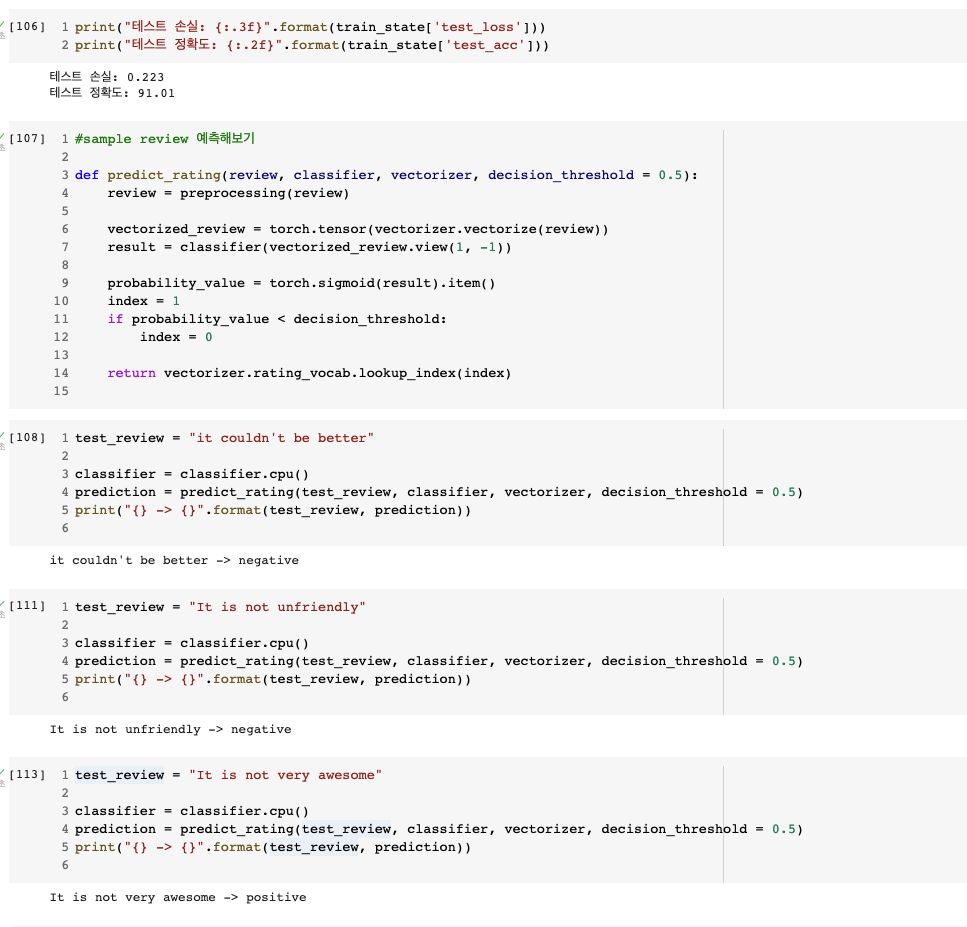